# QASSIS: _Quality Algorithm to Search Stuff In Spectra_



In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as sig
from lmfit import minimize, Parameters, fit_report, Model, Parameter
import corner as corner
%matplotlib inline
from pylab import rcParams

rcParams['figure.figsize'] = 15, 10


In [79]:
# Get spectrum file
spectrum_file = "181_WSW_FTS200_3mm_average_data_Tmb.dat"
spectrum = np.loadtxt(spectrum_file)

frequencies = spectrum[:,0]
intensities = spectrum[:,1]

# Get molecular catalog file
molecule_name = "CH3CN"
molecule_file = "CH3CN.txt"
molecule_catalog = pd.read_csv(molecule_file, delimiter="\t", header=0, index_col=False)

molecule_frequencies = molecule_catalog["Frequency(Ghz)"]
molecule_intensities = molecule_catalog["Intensity(K)"]
molecule_eup = molecule_catalog["Eup(K)"]
molecule_aij = molecule_catalog["Aij"]
molecule_transition = molecule_catalog["Transition"]

In [80]:
# Find possible emission lines
width = 0.5 

peaks = sig.find_peaks(intensities)[0]
peak_intensities = intensities[peaks]
peak_frequencies = frequencies[peaks]

noise = 2*5e-3
rms = [5*5e-3 for p in peak_frequencies]

emission_line_frequencies = []
emission_line_intensities = []
emission_line_eup = []
emission_line_aij = []
emission_line_transition = []

for i,f1 in enumerate(peak_frequencies):
    for j,f2 in enumerate(molecule_frequencies):
        if abs(f1-f2) < width and peak_intensities[i]>rms[i]:
            emission_line_frequencies.append(f1)
            emission_line_intensities.append(peak_intensities[i])
            emission_line_eup.append(molecule_eup[j])
            emission_line_aij.append(molecule_aij[j])
            emission_line_transition.append(molecule_transition[j])
            
print(emission_line_frequencies)

[73588.7747, 73590.3372, 91985.2624, 91987.0202, 110381.359, 110383.508]


# Fit Gaussians to Emission Lines

## Find best fit by least-squares and then feed that result to *emcee* (Foreman-Mackey 2019)

In [81]:
# Define a window for each line

window_size = 5 # default 5

window_frequencies = []
window_intensities = []

for f in emission_line_frequencies:
    window_f = frequencies[abs(frequencies-f)<window_size]
    window_i = intensities[abs(frequencies-f)<window_size]
    window_frequencies.append(window_f)
    window_intensities.append(window_i)
    
# For each window, define what the BASELINE is

baseline_frequencies = []
baseline_intensities = []

for i,window in enumerate(window_frequencies):
    baseline_window_frequencies = []
    baseline_window_intensities = []
    for j,freq in enumerate(window):
        if window_intensities[i][j] <= abs(noise) and abs(freq-emission_line_frequencies[i]) > 2*width:
            baseline_window_frequencies.append(freq)
            baseline_window_intensities.append(window_intensities[i][j])
    baseline_frequencies.append(baseline_window_frequencies)
    baseline_intensities.append(baseline_window_intensities)
    
# Fit a polynomial to the baseline
degree = 2

baseline_polynomials = []

for i,baseline_window_frequencies in enumerate(baseline_frequencies):
    baseline_fit = np.polyfit(baseline_window_frequencies, baseline_intensities[i], degree)
    baseline = np.poly1d(baseline_fit)
    baseline_polynomials.append(baseline)
    
# Subtract baseline polynomial from window intensities

window_intensities_corrected = []

for i,window in enumerate(window_intensities):
    window_intensities_corrected.append(window_intensities[i]-baseline_polynomials[i](window_frequencies[i]))
    
# For each window, define what the LINE is

line_frequencies = []
line_intensities = []

for i,window in enumerate(window_frequencies):
    line_window_frequencies = []
    line_window_intensities = []
    for j,freq in enumerate(window):
        if abs(freq-emission_line_frequencies[i]) <= 2*width and window_intensities_corrected[i][j]>=0:
            line_window_frequencies.append(freq)
            line_window_intensities.append(window_intensities_corrected[i][j])
    line_frequencies.append(line_window_frequencies)
    line_intensities.append(line_window_intensities)
    
# Fit a Gaussian to the line

gaussian_fits = []

def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (np.sqrt(2*np.pi) * wid)) * np.exp(-(x-cen)**2 / (2*wid**2))

for i,line_f in enumerate(line_frequencies):
    x = line_frequencies[i]
    y = line_intensities[i]
    
    # Do least squares first
    gmodel = Model(gaussian)
    params = gmodel.make_params()
    params["amp"] = Parameter(name='amp', value=0.01)
    params["cen"] = Parameter(name='cen', value=emission_line_frequencies[i], min=emission_line_frequencies[i]-3, max=emission_line_frequencies[i]+3)
    params["wid"] = Parameter(name='wid', value=width)
    
    result = gmodel.fit(y, x=x, params=params, method="leastsq")
    
    # Now do MCMC
    
    amp = result.best_values["amp"]
    cen = result.best_values["cen"]
    wid = result.best_values["wid"]
    
    gmodel = Model(gaussian)
    params = gmodel.make_params()
    params["amp"] = Parameter(name='amp', value=amp, min=max(0,amp-1*result.params["amp"].stderr), max=amp+1*result.params["amp"].stderr)
    params["cen"] = Parameter(name='cen', value=cen, min=cen-1, max=cen+1)
    params["wid"] = Parameter(name='wid', value=wid, min=max(0,wid-1*result.params["wid"].stderr), max=wid+1*result.params["wid"].stderr)
    
    result = gmodel.fit(y, x=x, params=params, method="emcee")

    
    
    gaussian_fits.append(result)
    print(result.fit_report())

# Define a linspace in each window for plotting purposes

window_linspaces = []
for i,window in enumerate(window_frequencies):
    window_linspaces.append(np.linspace(min(window), max(window),10000))

  3%|▎         | 26/1000 [00:00<00:03, 258.70it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [        nan         nan 78.67644723]
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 4
    # variables        = 3
    chi-square         = 2.9329e-04
    reduced chi-square = 2.9329e-04
    Akaike info crit   = -32.0825358
    Bayesian info crit = -33.9236527
[[Variables]]
    amp:  0.02059085 +/- 0.00752358 (36.54%) (init = 0.02059118)
    cen:  73588.8611 +/- 0.78764624 (0.00%) (init = 73588.8)
    wid:  0.17382975 +/- 0.06870867 (39.53%) (init = 0.1738342)


  3%|▎         | 29/1000 [00:00<00:03, 283.59it/s]

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 9
    # variables        = 3
    chi-square         = 0.00103787
    reduced chi-square = 1.7298e-04
    Akaike info crit   = -75.6103031
    Bayesian info crit = -75.0186293
[[Variables]]
    amp:  0.02411077 +/- 0.00328635 (13.63%) (init = 0.0241108)
    cen:  73590.2367 +/- 0.77143393 (0.00%) (init = 73590.25)
    wid:  0.13547158 +/- 0.02738685 (20.22%) (init = 0.1354792)


  3%|▎         | 30/1000 [00:00<00:03, 296.09it/s]

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 5
    # variables        = 3
    chi-square         = 9.1995e-04
    reduced chi-square = 4.5998e-04
    Akaike info crit   = -37.0031215
    Bayesian info crit = -38.1748078
[[Variables]]
    amp:  0.01867070 +/- 7.9997e-04 (4.28%) (init = 0.01866991)
    cen:  91985.4180 +/- 0.80452757 (0.00%) (init = 91985.33)
    wid:  0.13385633 +/- 0.00796874 (5.95%) (init = 0.1338594)


  3%|▎         | 31/1000 [00:00<00:03, 302.82it/s]

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 6
    # variables        = 3
    chi-square         = 0.00168029
    reduced chi-square = 5.6010e-04
    Akaike info crit   = -43.0832775
    Bayesian info crit = -43.7079990
[[Variables]]
    amp:  0.02268149 +/- 4.6177e-04 (2.04%) (init = 0.02268154)
    cen:  91986.9950 +/- 0.82132780 (0.00%) (init = 91987.11)
    wid:  0.13034660 +/- 0.00430506 (3.30%) (init = 0.1303445)


  3%|▎         | 34/1000 [00:00<00:02, 333.86it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [         nan 105.16882017          nan]
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 7
    # variables        = 3
    chi-square         = 9.6780e-05
    reduced chi-square = 2.4195e-05
    Akaike info crit   = -72.3228659
    Bayesian info crit = -72.4851354
[[Variables]]
    amp:  0.01195755 +/- 6.3972e-04 (5.35%) (init = 0.01195748)
    cen:  110381.433 +/- 0.81824337 (0.00%) (init = 110381.4)
    wid:  0.16886265 +/- 0.01005628 (5.96%) (init = 0.1688536)


100%|██████████| 1000/1000 [00:05<00:00, 184.90it/s]

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 10
    # variables        = 3
    chi-square         = 8.3226e-04
    reduced chi-square = 1.1889e-04
    Akaike info crit   = -87.9395133
    Bayesian info crit = -87.0317580
[[Variables]]
    amp:  0.01119518 +/- 9.7481e-04 (8.71%) (init = 0.01119499)
    cen:  110383.660 +/- 0.81077398 (0.00%) (init = 110383.6)
    wid:  0.11676701 +/- 0.01465081 (12.55%) (init = 0.1167705)


## Check best fits

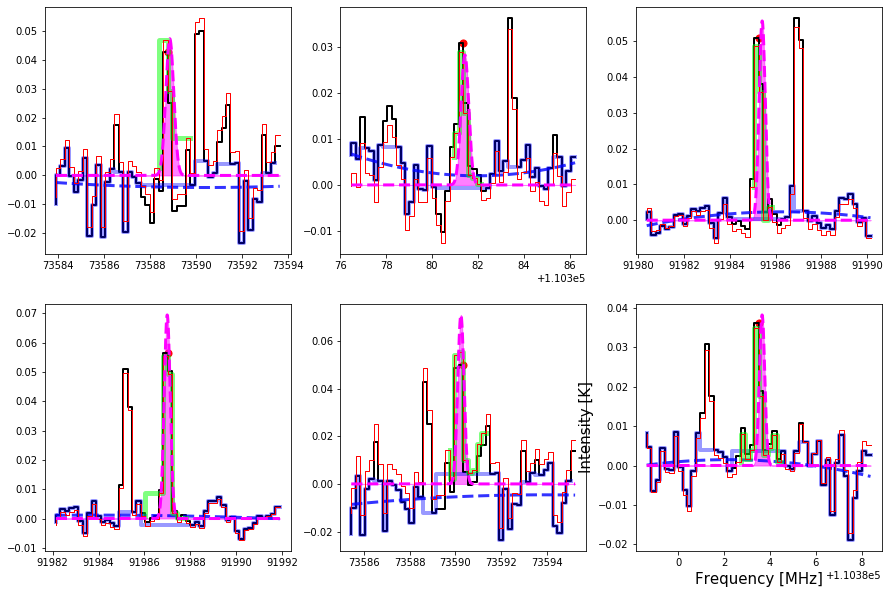

In [86]:
for i,line in enumerate(window_intensities):

    plt.subplot2grid((2,3),(i%2,i%3))
    plt.step(window_frequencies[i], window_intensities[i], linewidth=2, c="black")
    plt.step(baseline_frequencies[i], baseline_intensities[i], linewidth=4, c="blue", alpha=0.4)
    plt.scatter(emission_line_frequencies[i], emission_line_intensities[i], s=50, c="red")

    F_linspace = np.linspace(min(window_frequencies[i]), max(window_frequencies[i]),100)
    plt.plot(F_linspace, baseline_polynomials[i](F_linspace), color="blue", linestyle="--", linewidth=3, alpha=0.8)


    plt.step(line_frequencies[i], line_intensities[i], linewidth=5, c="lime", alpha=0.5)

    plt.step(window_frequencies[i], window_intensities_corrected[i], c="red", linewidth=1)

    amp = np.median(gaussian_fits[i].flatchain["amp"])
    cen = np.median(gaussian_fits[i].flatchain["cen"])
    wid = np.median(gaussian_fits[i].flatchain["wid"])
    
    #amp = gaussian_fits[i].best_values["amp"]
    #cen = gaussian_fits[i].best_values["cen"]
    #wid = gaussian_fits[i].best_values["wid"]
    
    gauss = gaussian(window_linspaces[i], amp, cen, wid)
    plt.plot(window_linspaces[i], gauss, linestyle='--', color="magenta", label='best fit', linewidth=3)

    plt.fill_between(window_linspaces[i], y1=[0 for x in window_linspaces[i]], y2 =gauss , color="magenta", alpha=0.5)

plt.xlabel("Frequency [MHz]", fontsize=15)
plt.ylabel("Intensity [K]", fontsize=15)

plt.show()

## Correlation plots to double check _emcee_ didn't go insane

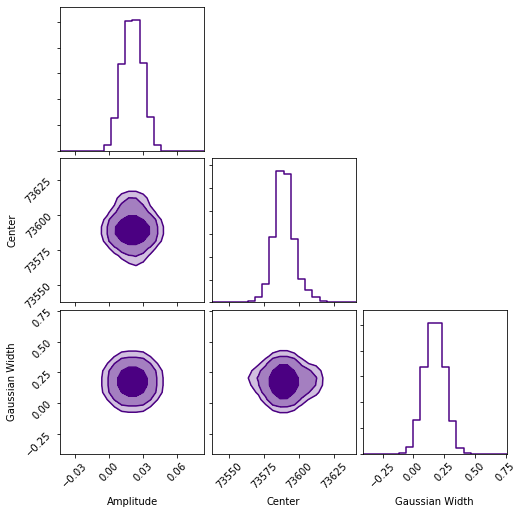

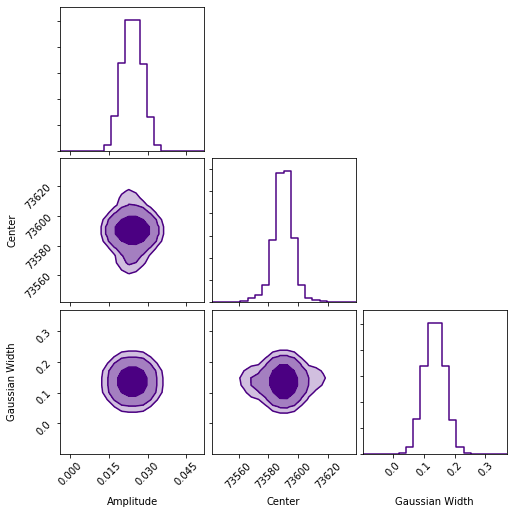

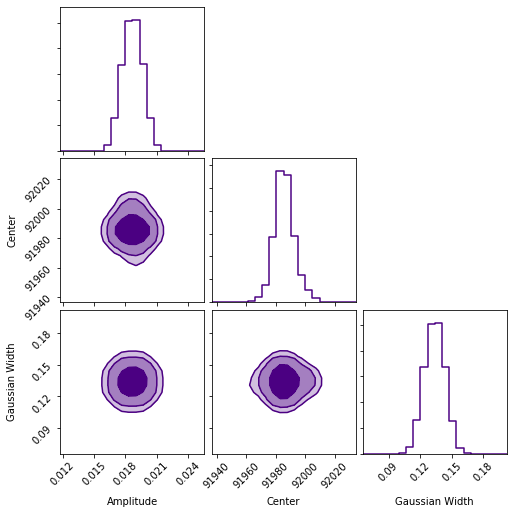

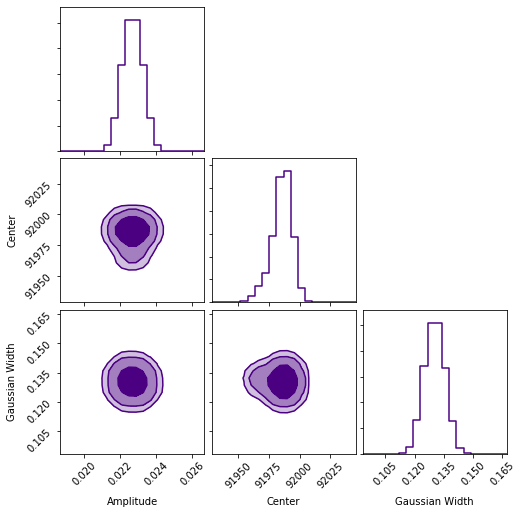

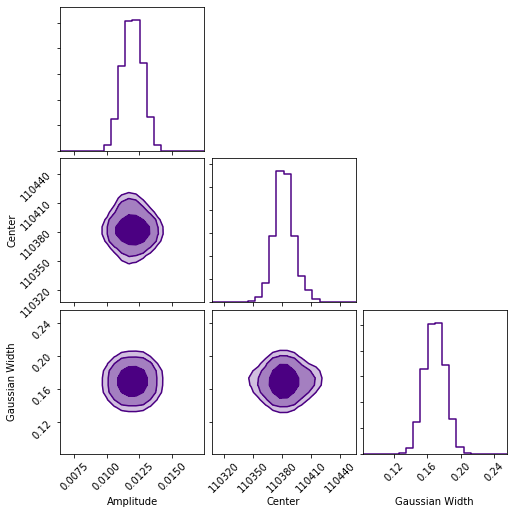

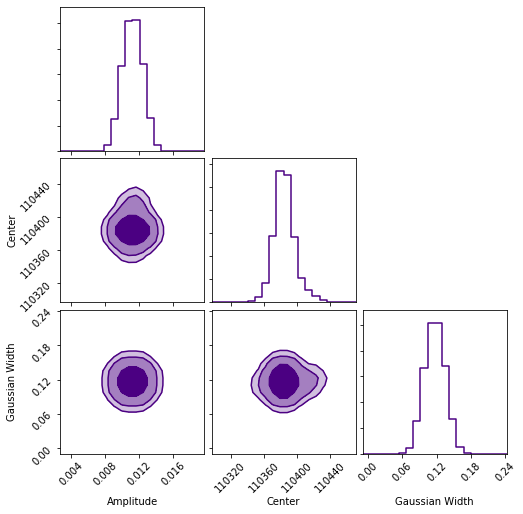

In [87]:
for i,line in enumerate(window_intensities):
    amp = np.median(gaussian_fits[i].flatchain["amp"])
    cen = np.median(gaussian_fits[i].flatchain["cen"])
    wid = np.median(gaussian_fits[i].flatchain["wid"])
    
    amp_err = np.std(gaussian_fits[i].flatchain["amp"])
    cen_err = np.std(gaussian_fits[i].flatchain["cen"])
    wid_err = np.std(gaussian_fits[i].flatchain["wid"])
    
    corner.corner(gaussian_fits[i].flatchain, bins=20, color="indigo", smooth=True, smooth1d=True,
             plot_datapoints=True, plot_density=False, fill_contours=True, levels=[0.67, 0.95,0.99],
                 range=[(amp-10*amp_err, amp+10*amp_err),(cen-10*cen_err, cen+10*cen_err),(wid-10*wid_err, wid+10*wid_err)],
                 labels=["Amplitude", "Center", "Gaussian Width"])

    
    
plt.show()
    

### Derive Rotation Diagrams

In [88]:
# EVERYTHING IN CGS UNITS

# Boltzmann Constant
k = 1.3807 * 1e-16 
# Dipole moment

# CH3CN
mu = 3.9037 * 1e-18

# CH3CCH
#mu = 0.784*3.33564*1e-30

# Transition strength
# CH3CN
strength = [5.16717, 5.51304, 6.61439, 6.89014, 8.03828, 8.26803]

# CH3CCH
#strength = [4.80000, 5.00100, 5.33400, 5.83400, 6.00100]


# The integral from -inf to inf is the amp parameter. Convert to K.cm/s

flux = [np.median(fit.flatchain["amp"])*100000 for fit in gaussian_fits] # in K . cm/s
flux_err = [np.std(fit.flatchain["amp"])*100000 for fit in gaussian_fits] # in K . cm/s

centers = [np.median(fit.flatchain["cen"])*1e6 for fit in gaussian_fits] # in K . cm/s
# Upper-level populations Nu/gu

lnnugu = np.log((3*k*np.array(flux))/(8*(np.pi**3)*np.array(centers)*(mu**2)*np.array(strength)))

nugu_err = ((3*k*np.array(flux_err))/(8*(np.pi**3)*np.array(centers)*(mu**2)*np.array(strength)))
lnnugu_err = nugu_err / np.exp(lnnugu)

emission_line_eup = np.array(emission_line_eup)

## Fit Rotation Diagram

100%|██████████| 1000/1000 [00:07<00:00, 134.00it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.39647795 25.06277312]
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 6
    # variables        = 2
    chi-square         = 183.199781
    reduced chi-square = 45.7999451
    Akaike info crit   = 24.5129067
    Bayesian info crit = 24.0964257
[[Variables]]
    T:         14.9239019 +/- 0.74178796 (4.97%) (init = 14.87059)
    lnNugu_0:  20.6881596 +/- 0.05406856 (0.26%) (init = 20.69279)
[[Correlations]] (unreported correlations are < 0.100)
    C(T, lnNugu_0) = -0.960


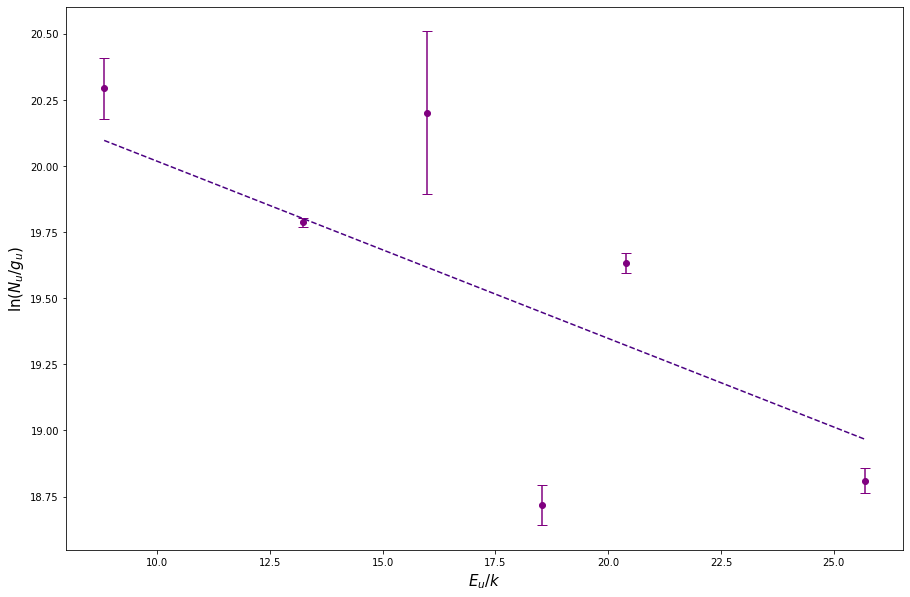

In [89]:
def residual(params, eu, data, eps_data):
    m = -1/params['T']
    b = params['lnNugu_0']
  
    model = m*eu+b

    return (data-model) / eps_data


params = Parameters()
params.add('T', value=10, min=0, max=100)
params.add('lnNugu_0', value=20, min=15, max=30)


out = minimize(residual, params, args=(np.array(emission_line_eup), lnnugu, lnnugu_err), method="leastsq")

T = out.params["T"]
lnNugu_0 = out.params["lnNugu_0"]

params = Parameters()
params.add('T', value=T, min=T-4*T.stderr, max=T+4*T.stderr)
params.add('lnNugu_0', value=lnNugu_0, min=lnNugu_0-4*lnNugu_0.stderr, max=lnNugu_0+4*lnNugu_0.stderr)

out = minimize(residual, params, args=(np.array(emission_line_eup), lnnugu, lnnugu_err), method="emcee")


print(fit_report(out))

T = np.median(out.flatchain["T"])
lnNugu_0 = np.median(out.flatchain["lnNugu_0"])

Eu_linspace = np.linspace(min(emission_line_eup), max(emission_line_eup), 1000)

def rotdiag_model(Eu, T, lnNugu_0):
    return lnNugu_0 - (1/T)*Eu

plt.scatter(emission_line_eup, lnnugu, c="purple")

plt.errorbar(emission_line_eup, lnnugu, yerr=lnnugu_err, capsize=5, c="purple", fmt="none")

plt.plot(Eu_linspace, rotdiag_model(Eu_linspace, T, lnNugu_0), color="indigo", linestyle="--")
    
plt.ylabel("$\ln(N_u/g_u)$", fontsize=15)
plt.xlabel("$E_u/k$", fontsize=15)
plt.show()
    


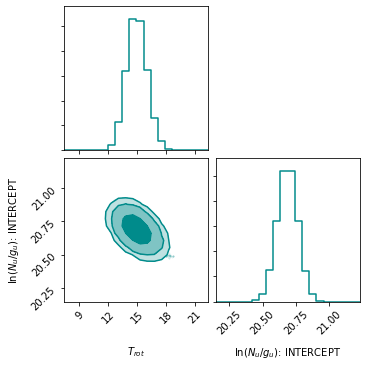

In [90]:
T_err = np.std(out.flatchain["T"])
lnNugu_0_err = np.std(out.flatchain["lnNugu_0"])
    
    
corner.corner(out.flatchain, bins=20, color="darkcyan", smooth=True, smooth1d=True,
             plot_datapoints=True, plot_density=False, fill_contours=True, levels=[0.67, 0.95,0.99],
                 range=[(T-10*T_err, T+10*T_err),(lnNugu_0-10*lnNugu_0_err, lnNugu_0+10*lnNugu_0_err)],
                 labels=["$T_{rot}$", "$\ln(N_u/g_u)$: INTERCEPT"])

plt.show()

## Derive total column density $N_{tot}$ by approximating the rotational partition function $Q_{rot}$

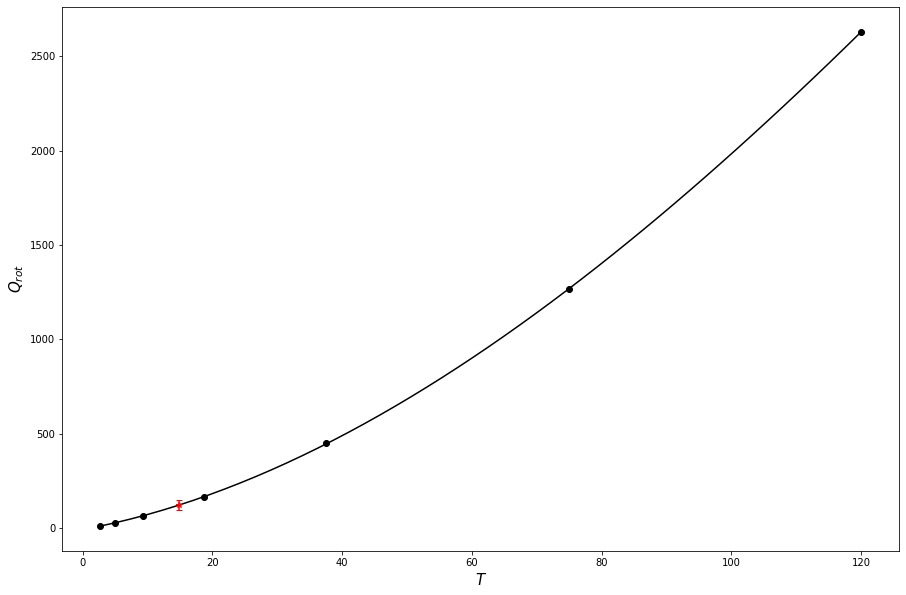

In [91]:
# CH3CN
Qrot = [13.8355, 28.4924, 64.0955, 164.3168, 449.0811, 1267.6705, 2628.0493]
Trot = [2.725, 5.0, 9.375, 18.75, 37.5, 75.0, 120.0]

Qfit = np.polyfit(Trot, Qrot, 3)
Q = np.poly1d(Qfit)

T_linspace = np.linspace(min(Trot), max(Trot))
plt.scatter(Trot, Qrot, c="black")
plt.plot(T_linspace, Q(T_linspace), color="black")

Qerr = np.sqrt((T*T_err)*(3*(Qfit[0]**2)*(T**4)+2*Qfit[1]*T**2+Qfit[1]**2))

plt.errorbar([T], [Q(T)], yerr=Qerr , c="red", fmt="*", capsize=3)

plt.ylabel("$Q_{rot}$", fontsize=15)
plt.xlabel("$T$", fontsize=15)
plt.show()

In [92]:
lnNtot = lnNugu_0 + np.log(Q(T))
lnNtot_err = np.sqrt((lnNugu_0_err)**2 + (Qerr/Q(T))**2)

logNtot = np.log10(np.exp(lnNtot))
logNtot_err = 0.434*(np.exp(lnNtot)*lnNtot_err/np.exp(lnNtot))

rot_err = np.sqrt((lnNugu_0_err)**2 + (np.array(Eu_linspace)*T**(-2)*T_err)**2)

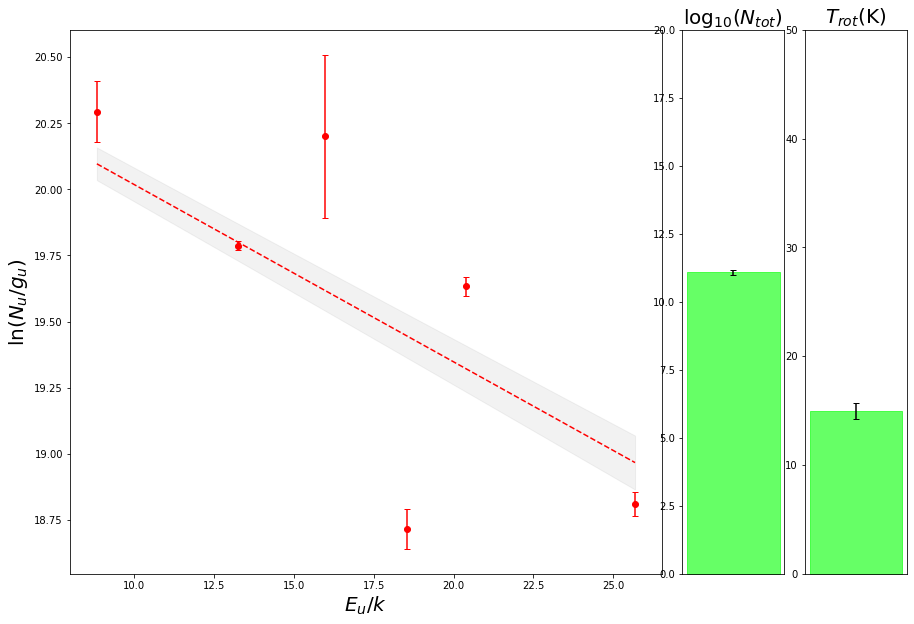

In [93]:
plt.subplot2grid((1,7), (0,0), colspan=5)

plt.errorbar(emission_line_eup, lnnugu, yerr=lnnugu_err, fmt="o", capsize=3, color="red")

plt.plot(Eu_linspace, rotdiag_model(Eu_linspace, T, lnNugu_0), color="red", linestyle="--")
    
plt.ylabel("$\ln(N_u/g_u)$", fontsize=20)
plt.xlabel("$E_u/k$", fontsize=20)


plt.fill_between(x=Eu_linspace, y1=rotdiag_model(Eu_linspace, T, lnNugu_0)-rot_err, y2=rotdiag_model(Eu_linspace, T, lnNugu_0)+rot_err, alpha=0.1, color="gray")

plt.subplot2grid((1,7), (0,5), colspan=1)
plt.errorbar([0], [logNtot], yerr=logNtot_err , c="black", capsize=3)

plt.fill_between(x=[-1,1],y1=0,y2=logNtot, color="lime", alpha=0.6)
plt.title("$\log_{10}(N_{tot})$", fontsize=20)

plt.xticks([])
plt.ylim([0,20])

plt.subplot2grid((1,7), (0,6), colspan=1)
plt.errorbar([0], [T], yerr=T_err , c="black", capsize=3)

plt.fill_between(x=[-1,1],y1=0,y2=T, color="lime", alpha=0.6)
plt.title("$T_{rot}$(K)", fontsize=20)

plt.xticks([])
plt.ylim([0,50])

plt.show()